**Description:** This notebook demonstrates the application of MYPGD to the Bayesian neural network considered in Section 3.2 of [Particle algorithms for maximum likelihood training of latent
variable models](https://juankuntz.github.io/publication/parem/) but changing the normal prior on the weights with Laplace priors that induce sparsity.

In [1]:
#@title Load modules.

# Numpy and JAX for computations.
import numpy as np
import jax
import jax.numpy as jnp
import torch

# Pyplot for plots.
import matplotlib.pyplot as plt 

Next, we load and curate the dataset:

In [2]:
#@title Load, subsample, and normalize MNIST dataset.

# Load dataset:
from keras.datasets import mnist
(images, labels), _ = mnist.load_data()
images = np.array(images).astype(float)
labels = np.array(labels).astype(int)

# Keep only datapoints with labels 4 and 9:
indices = (labels == 4) | (labels == 9)
labels = labels[indices]
images = images[indices, :, :]

# Relabel as 4 as 0 and 9 as 1:
for n in range(labels.size):
    if labels[n] == 4:
        labels[n] = 0
    else:
        labels[n] = 1

# Sub-sample 1000 images:
from sklearn.model_selection import train_test_split
images, _, labels, _ = train_test_split(images, labels, train_size=1000,
                                        random_state=0)

# Normalize non-zero entries (pixels across whole dataset) so that they have mean zero 
# and unit standard across the dataset:
i = images.std(0) != 0
images[:, i] = (images[:, i] - images[:, i].mean(0))/images[:, i].std(0)

2024-04-08 10:37:52.546098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 10:37:52.546133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 10:37:52.546884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 10:37:53.109746: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.
*   gamma: Smoothing parameter of the Moreau-Yosida envelope.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

In [3]:
# Algorithms
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  
sys.path.append(project_root)

from bayesian_neural_network.algorithms import my_pgd_bnn, my_pgd_bnn_performance

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.chdir(project_root)

We can now run the algorithms using an 80/20 training/test split of the data:

In [4]:
# Split data into 80/20 training and testing sets:
itrain, itest, ltrain, ltest = train_test_split(images, labels, test_size=0.2,
                                                random_state=0)

# Set approximation parameters:
h = 5e-2 # Step-size. 
K = 500  # Number of steps.
N = 100  # Number of particles.
gamma = 0.5 # Smoothing parameter

# Initialize parameter estimates:
a0 = np.array([1])  # Alpha.
b0 = np.array([1])  # Beta.

# Initialize particle cloud by sampling prior:'
w0 = np.exp(a0)*np.random.normal(0, 1, (40, 28**2, N))  # Input layer weights.
v0 = np.exp(b0)*np.random.normal(0, 1, (2, 40, N))  # Output layer weights.

# Run algorithms:
a_pgd, b_pgd, w_pgd, v_pgd, lppd_pgd, error_pgd = my_pgd_bnn(ltrain, itrain, ltest, 
                                                      itest, h, K, a0, b0, w0, 
                                                      v0, gamma)

100%|██████████| 500/500 [01:32<00:00,  5.39it/s]


Sanity check, we plot the test error throught training:

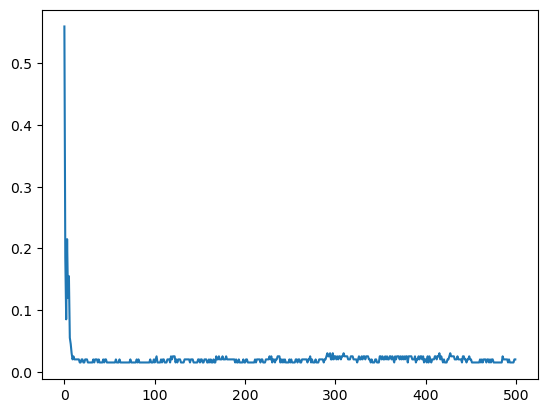

In [5]:
plt.plot(error_pgd, label='PGD') 

(-5.0, 500.0)

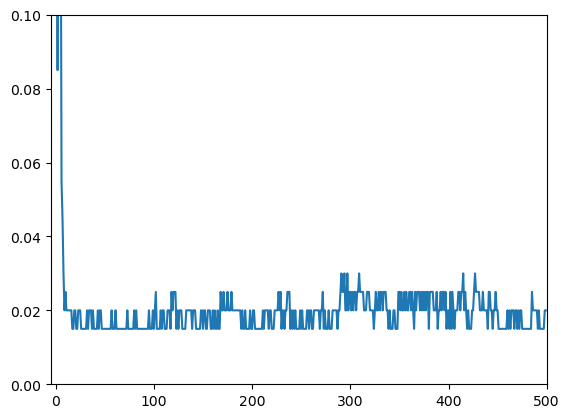

In [6]:
plt.plot(error_pgd, label='PGD') 
plt.ylim([0, 0.1])
plt.xlim([-K/100, K])

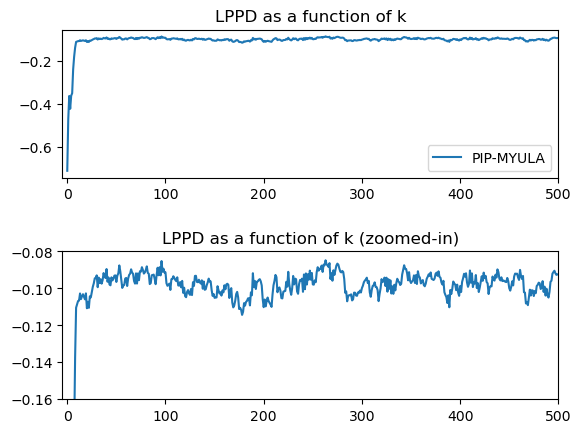

In [9]:
plt.subplot(2, 1, 1)
plt.plot(lppd_pgd, label='MYPGD') 
plt.title('LPPD as a function of k')
plt.xlim([-K/100, K])
plt.legend(loc='lower right', ncol=4)

plt.subplot(2, 1, 2)
plt.plot(lppd_pgd, label='MYPGD') 
plt.title('LPPD as a function of k (zoomed-in)')
plt.ylim([-0.16, -0.08])
plt.xlim([-K/100, K])

plt.subplots_adjust(hspace=0.5)

### Predictive performance

In [10]:
from bayesian_neural_network.algorithms import log_pointwise_predictive_density, test_error

In [11]:
# Split data into 80/20 training and testing sets:
itrain, itest, ltrain, ltest = train_test_split(images, labels, test_size=0.2,
                                                random_state=0)

# Set approximation parameters:
h = 5e-2 # Step-size. 
K = 500  # Number of steps.
gamma = 0.5 # Smoothing parameter

# Initialize parameter estimates:
a0 = np.array([0])  # Alpha.
b0 = np.array([0])  # Beta.

In [15]:
M = 10 # Number of runs.
N = 10 # Number of particles.

# Initialize arrays storing the LPPDs and test errors:
lppd_pgd = np.zeros((M))
error_pgd = np.zeros((M))

for m in range(M):
    print('Run ' + str(m) + ' out of ' + str(M) + '.')
    
    # Randomize the initialization of the particle cloud:
    w0 = np.exp(a0)*np.random.normal(0, 1, (40, 28**2, N))  # w-components.
    v0 = np.exp(b0)*np.random.normal(0, 1, (2, 40, N))  # v-components.
    
    # Randomize the 80/20 testing/training split of the data:
    itrain, itest, ltrain, ltest = train_test_split(images, labels, 
                                                    test_size=0.2,
                                                    random_state=m)

    # Run the algorithms:
    _, _, w_pgd, v_pgd = my_pgd_bnn_performance(ltrain, itrain, h, K, a0, b0, w0, v0, gamma)
    
    # Compute LPPDs:
    lppd_pgd[m] = log_pointwise_predictive_density(w_pgd, v_pgd, itest, ltest)

    # Compute test errors:
    error_pgd[m] = test_error(w_pgd, v_pgd, itest, ltest)

# Print statistics (mean +- standard deviation):
print('LPPDs:')
print('PIP-MYULA: '+str(lppd_pgd.mean())+' \u00B1 '+str(lppd_pgd.std())+'.')

print('Test errors:')
print('PIP-MYULA: '+str(error_pgd.mean())+' \u00B1 '+str(error_pgd.std())+'.')

Run 0 out of 10.


100%|██████████| 500/500 [00:10<00:00, 47.44it/s]


Run 1 out of 10.


100%|██████████| 500/500 [00:11<00:00, 44.91it/s]


Run 2 out of 10.


100%|██████████| 500/500 [00:11<00:00, 44.36it/s]


Run 3 out of 10.


100%|██████████| 500/500 [00:11<00:00, 44.40it/s]


Run 4 out of 10.


100%|██████████| 500/500 [00:10<00:00, 46.86it/s]


Run 5 out of 10.


100%|██████████| 500/500 [00:11<00:00, 45.31it/s]


Run 6 out of 10.


100%|██████████| 500/500 [00:10<00:00, 46.61it/s]


Run 7 out of 10.


100%|██████████| 500/500 [00:10<00:00, 45.68it/s]


Run 8 out of 10.


100%|██████████| 500/500 [00:10<00:00, 46.23it/s]


Run 9 out of 10.


100%|██████████| 500/500 [00:10<00:00, 46.49it/s]

LPPDs:
PIP-MYULA: -0.12493112534284592 ± 0.04860899264694565.
Test errors:
PIP-MYULA: 0.03149999920278788 ± 0.011412712171669856.


In [16]:
from timeit import repeat
    
# Time the algorithms:
t_pgd = np.array(repeat(stmt='my_pgd_bnn_performance(ltrain, itrain, h, K, a0, b0, w0, v0, gamma)',
                       number=1, repeat=M, globals=globals()))

# Print statistics (mean +- standard deviation):
print('Runtimes:')
print('PGD: '+str(t_pgd.mean())+' \u00B1 '+str(t_pgd.std())+'.')

100%|██████████| 500/500 [00:10<00:00, 48.28it/s]

Runtimes:
PGD: 10.845213848204002 ± 0.27543886953194247.
